In [8]:
## Load Imports ##
import nibabel as nib
import numpy as np
from scipy import stats


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import dice_coef
from data_generator import DataGenerator
from data_loader import *

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap="gray", origin="lower")

def show_slice(slice):
    plt.imshow(slice.T, cmap="gray", origin="lower")
    
def normalizeImg(x):
    # Normalize x
    max_val = np.max(x)
    min_val = np.min(x)
    norm_x = (x-min_val)/(max_val-min_val + 1e-7)
    return norm_x

def thresholdMask(mask, threshold=0.56):
    mask[mask >= threshold] = 1.0
    mask[mask < threshold] = 0.0
    return mask


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
slice_type = 'side'
train_dir = ('../slice_data_' + slice_type + '_test')
dim =(256,256)
# Loading Data
print('Loading Data...')
partition={}
(partition['x_train'],
partition['y_train'],
partition['x_val'],
partition['y_val'],
partition['x_test'],
partition['y_test'])  = load_data(train_dir, split=(100, 0, 0))
# Parameters for input data
params1 = {'dim': dim,
          'batch_size': 1,
          'n_channels': 1,
          'shuffle': False}

training_generator = DataGenerator(partition['x_train'], partition['y_train'], **params1)

print(len(training_generator))
'''
for input_ex in partition['x_train']:
    print(input_ex)
'''

Loading Data...
7456


"\nfor input_ex in partition['x_train']:\n    print(input_ex)\n"

../slice_data_side_test/IXI249-Guys-1072-T1_side_104.nii
-------- Input ---------
(256, 256)


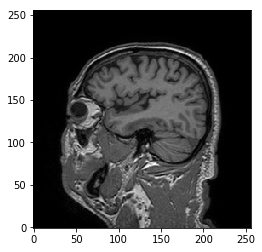

DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.17674671198237135, variance=0.0367511217869681, skewness=0.6805955854095795, kurtosis=-0.5479789915281827)
-------- Mask Edited ---------
(256, 256)


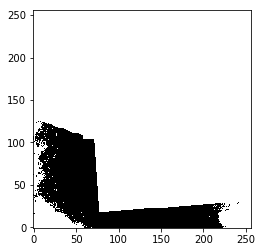

DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.8467559814453125, variance=0.12976226934699434, skewness=-1.9252319232287993, kurtosis=1.7065179582192629)
-------- Original ---------


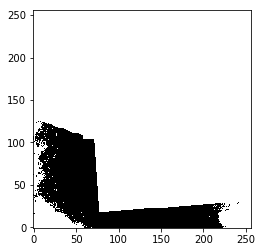

DescribeResult(nobs=65536, minmax=(0, 1), mean=0.8467559814453125, variance=0.12976226934699434, skewness=-1.9252319232287993, kurtosis=1.7065179582192629)
-------- Predicted ---------


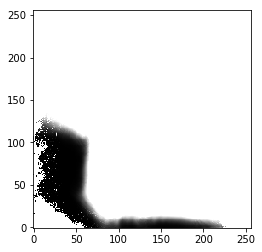

DescribeResult(nobs=65536, minmax=(1.3428557e-10, 0.63218844), mean=0.5700067, variance=0.031731915, skewness=-2.6492297649383545, kurtosis=5.230822700475635)
-------- Predicted ---------


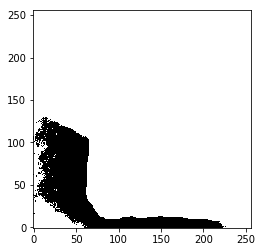

DescribeResult(nobs=65536, minmax=(0.0, 1.0), mean=0.8829498, variance=0.103350975, skewness=-2.382417917251587, kurtosis=3.675916693094207)
-------- Dice Coef. ---------


0.8429490798238681

In [13]:
%matplotlib inline
#example to look at
num_example = 8
print(partition['x_train'][8])
example_x = ((training_generator[num_example])[0])[0, :, :, 0]
example_y = ((training_generator[num_example])[1])[0, :, :, 0]

print('-------- Input ---------')
print(example_x.shape)
show_slice(example_x)
plt.show()
print(stats.describe(example_x, axis=None))

print('-------- Mask Edited ---------')
print(example_y.shape)
show_slice(example_y)
plt.show()
print(stats.describe(example_y, axis=None))

print('-------- Original ---------')
ex1 = partition['y_train'][num_example]
ex1_data = nib.load(ex1).get_data()
show_slice(ex1_data)
plt.show()
print(stats.describe(ex1_data, axis=None))

#../slice_data_back_val/IXI166-Guys-0846-T1_back_10.nii
print('-------- Predicted ---------')
ex1_pred = partition['y_train'][num_example].replace('mask_', 'mask_pred_')
ex1_pred = ex1_pred.replace('test','test_pred')
ex1_pred_data = (nib.load(ex1_pred).get_data())[:,:,0]
show_slice(ex1_pred_data)
plt.show()
print(stats.describe(ex1_pred_data, axis=None))

print('-------- Predicted ---------')
thresh = 0.56
thresh_pred = thresholdMask(ex1_pred_data, thresh)
show_slice(thresh_pred)
plt.show()
print(stats.describe(thresh_pred, axis=None))

print('-------- Dice Coef. ---------')
# Predicted Dice Score
dice_coef(example_y, ex1_pred_data, threshold=thresh)



In [31]:
# Determine Dice Ceoficient
samples = len(training_generator)-1 if len(training_generator) < 40 else 40
#samples = len(training_generator)-1
print(samples)
idx = 0
thresh = 0.55
dc_list = []
for x, y in training_generator:
    example_x = ((x))[0, :, :, 0]
    example_y = ((y))[0, :, :, 0]
    # Get the predicted example
    ex1_pred = partition['y_train'][idx].replace('mask_', 'mask_pred_')
    ex1_pred = ex1_pred.replace('val','val_pred')
    if not os.path.isfile(ex1_pred):
        continue
    ex1_pred_data = (nib.load(ex1_pred).get_data())[:,:,0]
    # Compute the dice coefficient
    dc = dice_coef(example_y, ex1_pred_data, threshold=thresh)
    if dc != -1:
        dc_list.append(dc)
    if samples == idx:
        break 
    idx+=1


40


KeyboardInterrupt: 

In [145]:
# Compute stats of dc_list
print(stats.describe(dc_list, axis=None))



DescribeResult(nobs=2550, minmax=(0.0, 0.9855423772833521), mean=0.8716185184602959, variance=0.020670195816588816, skewness=-3.3963365160039913, kurtosis=13.31258171209781)


In [6]:
# Test Precision
%load_ext autoreload
%autoreload 2
from metrics import prec_score
samples = len(training_generator)-1 if len(training_generator) < 40 else 40

idx = 0
thresh = 0.55
pc_list = []
for x, y in training_generator:
    example_x = ((x))[0, :, :, 0]
    example_y = ((y))[0, :, :, 0]
    # Get the predicted example
    ex1_pred = partition['y_train'][idx].replace('mask_', 'mask_pred_')
    ex1_pred = ex1_pred.replace('test','test_pred')
    #if not os.path.isfile(ex1_pred):
    #    continue
    ex1_pred_data = (nib.load(ex1_pred).get_data())[:,:,0]
    # Compute the dice coefficient
    pc = prec_score(example_y, ex1_pred_data)
    print(pc)
    pc_list.append(pc)
    if samples == idx:
        break 
    idx+=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.9622190339550454
0.8261234775304493
0.982879105520615
0.9946497241264003
0.9306163691478613
0.7607663614784673
0.9948995855913293
0.7020725388601037
0.9935964453737585
0.9714008725157538
0.7859279645805911
0.8123218592413944
0.8084722222222223
0.851184648521637
0.9104122863150197
0.8221599859968493
0.7422176485721637
0.9371384496721944
0.9967337115351556
0.9044572403497547
0.9179956353869397
0.999164159144099
0.9796380090497737
0.966650012490632
0.7127596439169139
0.9881737107405971
0.999090219863533
0.938384381157084
0.9449452672247264
0.6356282581341003
0.8476801867522614
0.7217665615141956
0.7706919945725916
0.999025069637883
0.98896911351785
0.8559770937723694
0.9298098434004475
0.9989146164978292
0.8405041813113562
0.8548516439454691
0.8984103589851563


In [7]:
# Test Recall
%load_ext autoreload
%autoreload 2
from metrics import rec_score
samples = len(training_generator)-1 if len(training_generator) < 40 else 40

idx = 0
thresh = 0.55
rc_list = []
for x, y in training_generator:
    example_x = ((x))[0, :, :, 0]
    example_y = ((y))[0, :, :, 0]
    # Get the predicted example
    ex1_pred = partition['y_train'][idx].replace('mask_', 'mask_pred_')
    ex1_pred = ex1_pred.replace('test','test_pred')
    #if not os.path.isfile(ex1_pred):
    #    continue
    ex1_pred_data = (nib.load(ex1_pred).get_data())[:,:,0]
    # Compute the dice coefficient
    rc = rec_score(example_y, ex1_pred_data)
    print(pc)
    rc_list.append(rc)
    if samples == idx:
        break 
    idx+=1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
0.8984103589851563
